In [1]:
from tardis.io.atom_data.util import download_atom_data
from tardis.io.config_reader import Configuration
from tardis.simulation import Simulation
from tardis.visualization import SDECPlotter
import matplotlib.pyplot as plt
import os

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

# Inner Boundary Velocity Solver (First Objective)

## Method 1: Zoom-in serial search

This method is quite naive. In this method, I take a search interval (min_v, max_v) and divide this interval into 5 equally-spaced points p1, p2, ..., p5. I then find the point p_i which gave the best w, and now I want to look in the neighborhood of p_i at a finer resolution. Hence I update the new search interval as (p_{i-1}, p_{i+1}), and repeat the process until the search interval reduces to a size of zero.<br>

Better explained in the pseudocode below:<br>

1. Take an initial search-interval (min_v, max_v)
2. Divide the search-interval into 5 equally-spaced points p1, p2, ..., p5
3. Find p_i which gives the best w. (Now we want to localize out search in this neighbourhood)
4. Update the search-interval to (p_{i-1}, p_{i+1})
5. If search-interval is non-zero, go to step 2; else exit

Pros:
- Easy to understand
- Give a very accurate result<br>
- Deterministic i.e. always gives the same result

Cons:
- Lots of iterations needed, expected to be slow. However, sometimes can get lucky (see metrics of Type 1a Multizone)

NOTE: The Zoom-in search script is located at `./IBVS/Type<Ia/IIp>/models/<multizone/uniform_ejecta>_model/run_task.py`<br>


## Method 2: Bayesian Optimisation

I use Bayesian Optimization to minimize the squared error term (w - 0.5)**2 on the input v_inner. I use [https://scikit-optimize.github.io/stable/](scikit-optimize) for this task. The number of iterations can be varied. I ran for 20 iterations and it gave pretty great results.<br>

Pros:
- Requires expected lesser number of iterations.
- Good external tools available

Cons:
- It could be argued it gives slightly worse results than Zoom-in search.
- Stochastic algorithm, sometimes gets unlucky.

NOTE: The config files I have used in this notebook correspond to the Bayesian Optimization solution with 20 iterations.<br><br>
NOTE: The Bayesian search script is located at `./IBVS/Type<Ia/IIp>/models/<multizone/uniform_ejecta>_model/run_task_bayesian.py`

In [2]:
# Helper function to run a simulation
def run_simulation(cfg_file):
    cfg = Configuration.from_yaml(cfg_file)
    cfg.config_dirname = ''
    virtual_packet_logging = cfg.montecarlo.no_of_virtual_packets > 0
    simulation = Simulation.from_config(cfg, virtual_packet_logging=virtual_packet_logging,
                                    show_progress_bars=True, log_level="CRITICAL")
    simulation.run()
    return simulation

In [3]:
# Helper function to plot spectrum
def plot_spectrum(orig_simulation, new_simulation, cfg_file):
    """Utility function for plotting two spectrums on same axis"""
    orig_plotter = SDECPlotter.from_simulation(orig_simulation)
    new_plotter = SDECPlotter.from_simulation(new_simulation)

    fig, axis = plt.subplots(figsize=(20, 10))

    cfg = Configuration.from_yaml(cfg_file)
    if cfg.montecarlo.no_of_virtual_packets > 0:
        packets_mode = 'virtual'
    else:
        packets_mode = 'real'

    # Compute plotting data
    orig_plotter._parse_species_list(species_list=None)
    orig_plotter._calculate_plotting_data(packets_mode=packets_mode, packet_wvl_range=None, distance=None, nelements=None)
    new_plotter._parse_species_list(species_list=None)
    new_plotter._calculate_plotting_data(packets_mode=packets_mode, packet_wvl_range=None, distance=None, nelements=None)

    # Plot modeled spectrum
    axis.plot(orig_plotter.plot_wavelength.value, orig_plotter.modeled_spectrum_luminosity.value,
            '--b', label=f'{packets_mode.capitalize()} Spectrum (Orig)', linewidth=1,)
    axis.plot(new_plotter.plot_wavelength.value, new_plotter.modeled_spectrum_luminosity.value, color='green',
            label=f'{packets_mode.capitalize()} Spectrum (New)', linewidth=1,)

    # Plot photosphere
    axis.plot(orig_plotter.plot_wavelength.value, orig_plotter.photosphere_luminosity.value,
        "--", color='red',
        label="Blackbody Photosphere (Orig)",
    )
    axis.plot(new_plotter.plot_wavelength.value, new_plotter.photosphere_luminosity.value,
        "--", color='orange',
        label="Blackbody Photosphere (New)",
    )

    # Set plot metadata
    axis.legend(fontsize=12)
    axis.set_xlabel(r"Wavelength $[\mathrm{\AA}]$", fontsize=12)
    _ = axis.set_ylabel(r"$L_{\lambda}$ [erg $\mathrm{s^{-1}}$ $\mathrm{\AA^{-1}}$]", fontsize=12)
    
    return fig

In [4]:
# Download atom data
download_atom_data("kurucz_cd23_chianti_H_He")

# Type 1A: Uniform Ejecta Model

#### Zoom-in Search Results:

Iterations taken to reach below error threshold (mse <= 1e-4) = 9<br>
Minimum squared error: 5.0207845458201043e-05<br>
Best W: 0.507085749463409<br>
Best Inner Velocity: 14780 km/s

#### Bayesian Optimization Results:

Minimum squared error: 9.13e-06<br>
Best W: 0.496<br>
Best Inner Velocity: 15089.769 km/s

In [ ]:
# Run simulation with original inner velocity
orig_sim = run_simulation('./TypeIa/models/uniform_ejecta_model/uniform_ejecta_model.yml')

In [ ]:
# Run simulation with new inner velocity
new_sim = run_simulation('./TypeIa/models/uniform_ejecta_model/uniform_ejecta_model_modified.yml')

In [7]:
print(new_sim.plasma.w[0])

0.49612422614484686


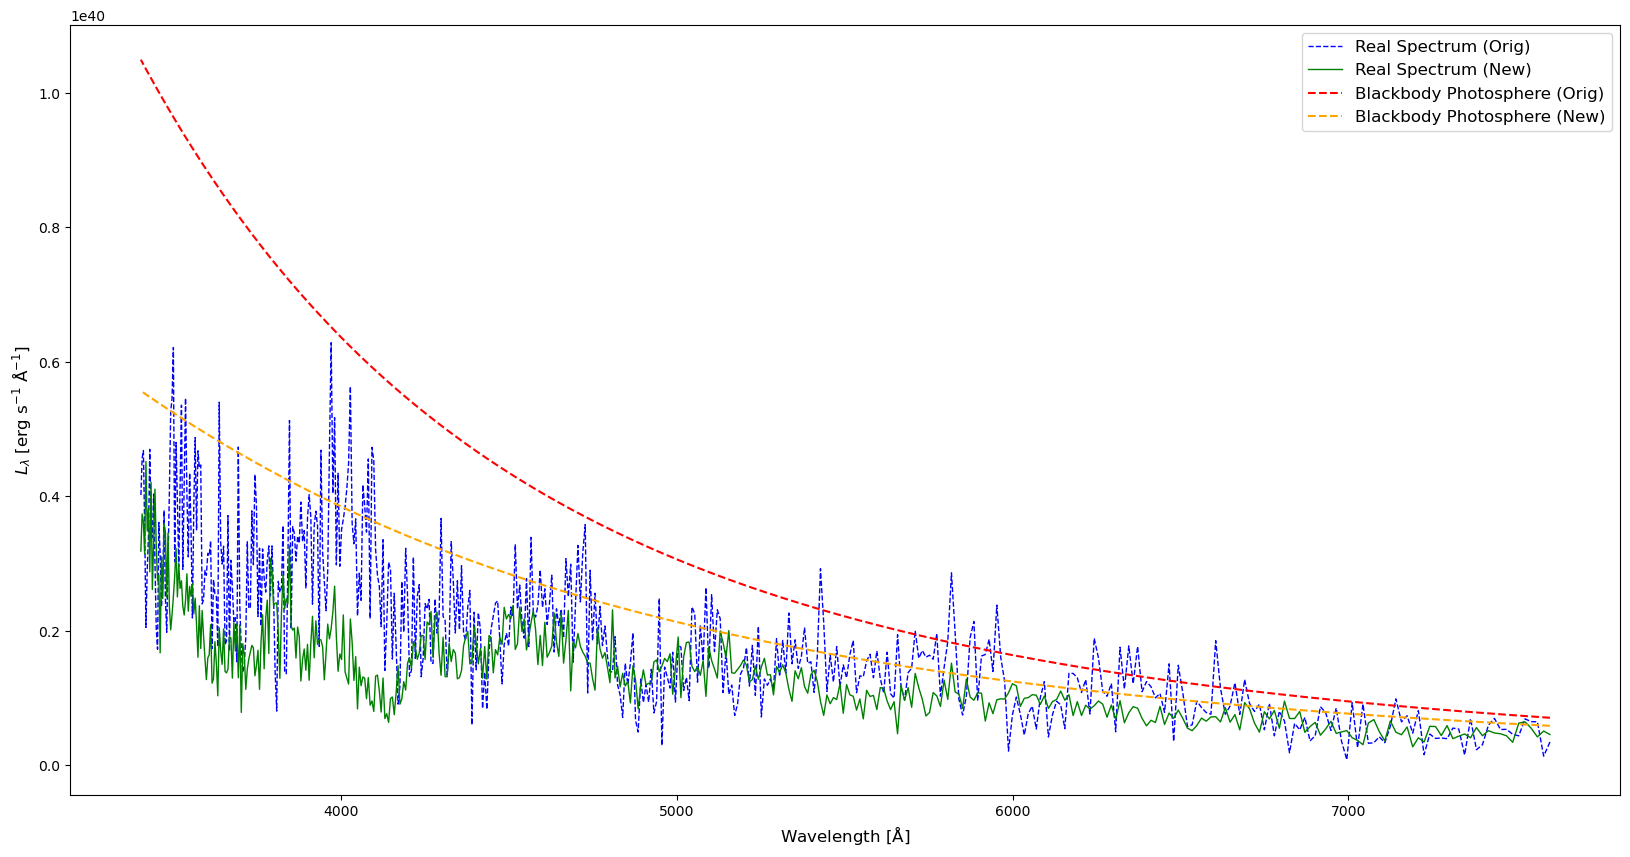

In [8]:
fig = plot_spectrum(orig_sim, new_sim, './TypeIa/models/uniform_ejecta_model/uniform_ejecta_model.yml')

# Type 1B: Multizone Model

#### Zoom-in Search Results:

Iterations taken to reach below error threshold (mse <= 1e-4) = 6 <---- Got lucky! <br>
Minimum squared error: 3.607813700044191e-05<br>
Best W: 0.5060065078873204<br>
Best Inner Velocity: 33891.65 km/s

#### Bayesian Optimization Results:

Minimum squared error: 5.765e-05 <br>
Best W: 0.492<br>
Best Inner Velocity: 26319.37 km/s 

In [ ]:
# Run simulation with original inner velocity
orig_sim = run_simulation('./TypeIa/models/multizone_model/multizone_model.yml')

In [ ]:
# Run simulation with new inner velocity
new_sim = run_simulation('./TypeIa/models/multizone_model/multizone_model_modified.yml')

In [7]:
print(new_sim.plasma.w[0])

0.4917312677484065


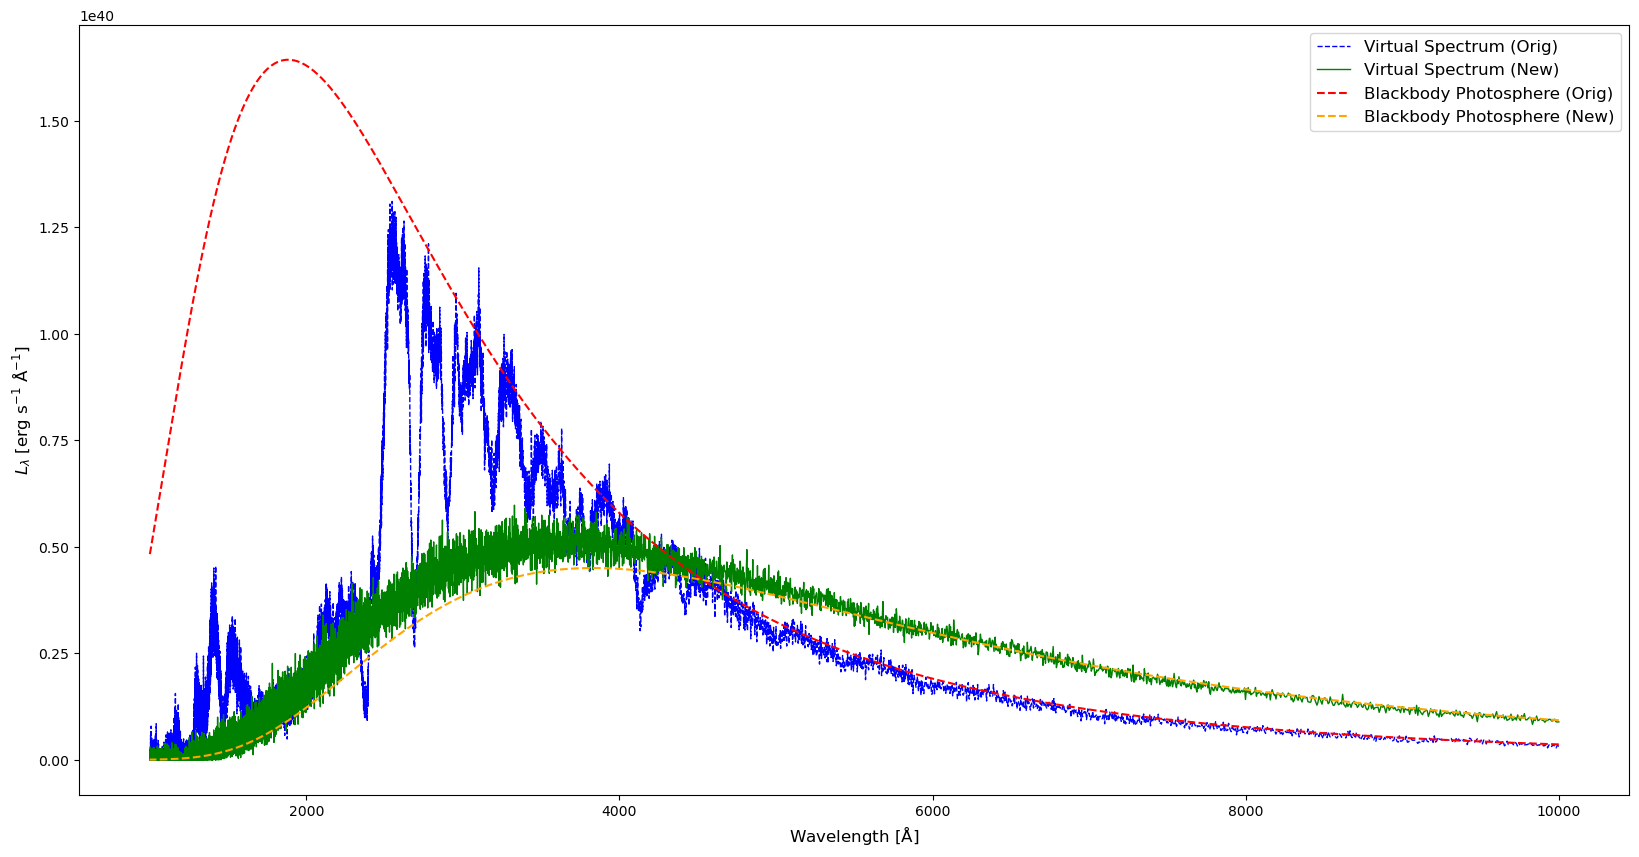

In [8]:
fig = plot_spectrum(orig_sim, new_sim, './TypeIa/models/multizone_model/multizone_model.yml')

# Type 2P: Uniform Ejecta Model

#### Zoom-in Search Results:

*Somehow the level-down search results for this model is too slow and always ends up crashing my process. Hence, I haven't populated the results here.*

Iterations taken to reach below error threshold (mse <= 1e-4) = ? <br>
Minimum squared error: ?<br>
Best W: ?<br>
Best Inner Velocity: ? km/s

#### Bayesian Optimization Results:

Minimum squared error: 2.43e-09 <br>
Best W: 0.49995<br>
Best Inner Velocity: 8259.884 km/s

In [ ]:
# Run simulation with original inner velocity
orig_sim = run_simulation('./TypeIIp/models/uniform_ejecta_model/uniform_ejecta_model.yml')

In [ ]:
# Run simulation with new inner velocity
new_sim = run_simulation('./TypeIIp/models/uniform_ejecta_model/uniform_ejecta_model_modified.yml')

In [11]:
print(new_sim.plasma.w[0])

0.49995069501784056


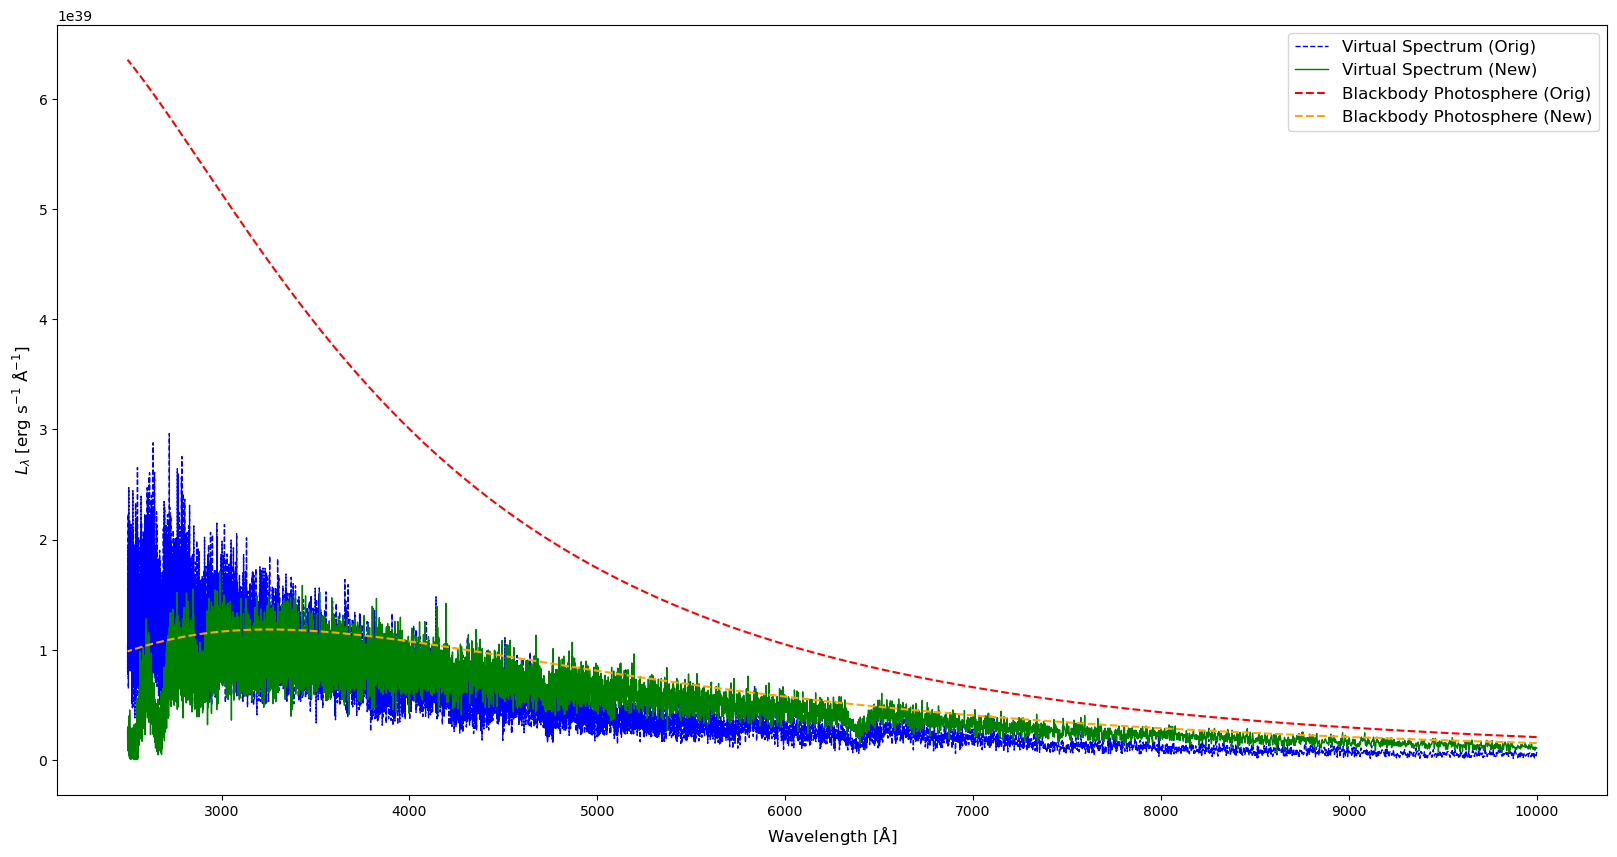

In [12]:
fig = plot_spectrum(orig_sim, new_sim, './TypeIIp/models/uniform_ejecta_model/uniform_ejecta_model.yml')